# **Predicting Solubility of Molecules**



## **1. Install rdkit**

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 27.6 MB/s eta 0:00:00


### **2. Download the dataset**

In [2]:
! wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

--2024-07-06 13:05:16--  https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889 (58K) [text/plain]
Saving to: ‘delaney.csv’

delaney.csv         100%[===================>]  57.51K  --.-KB/s    in 0.01s   

2024-07-06 13:05:16 (5.87 MB/s) - ‘delaney.csv’ saved [58889/58889]



### **3. Read in the dataset**

In [3]:
import pandas as pd

In [4]:
sol = pd.read_csv('delaney.csv')
sol

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


### **4. Examining the SMILES data**

Chemical structures are encoded by a string of text known as **SMILES** which is an acronym for **Simplified Molecular-Input Line-Entry System**.

In [5]:
sol.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

The first element from the **SMILES** column of the **sol** dataframe.

In [6]:
sol.SMILES[0]

'ClCC(Cl)(Cl)Cl'

### **5. Convert a molecule from the SMILES string to an rdkit object**

In [7]:
from rdkit import Chem

Compound name:  1,2-Dichloroethane


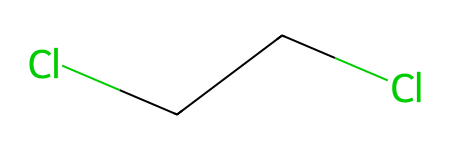

In [54]:

compound_id = sol.iloc[23]['Compound ID']
print("Compound name: ", compound_id)
Chem.MolFromSmiles(sol.SMILES[23])

In [9]:
m = Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

In [10]:
m.GetNumAtoms()

6

### **6. Convert list of molecules to rdkit object**

In [11]:
mol_list= []
for element in sol.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)

In [12]:
len(mol_list)

1144

In [13]:
mol_list[:5]

### **7. Calculate molecular descriptors**

To predict **LogS** (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:
1. **cLogP** *(Octanol-water partition coefficient)*
2. **MW** *(Molecular weight)*
3. **RB** *(Number of rotatable bonds)*
4. **AP** *(Aromatic proportion = number of aromatic atoms / total number of heavy atoms)*
5. **TPSA** *(Topological Polar Surface Area)*
5. **NumHDonors** *(Number of Hydrogen Bond Donors)*
5. **NumHAcceptors** *(Number of Hydrogen Bond Acceptors)*

 As for the AP descriptor, we will calculate this by manually computing the ratio of the *number of aromatic atoms* to the *total number of heavy atoms* which rdkit can compute.

#### **7.1. LogP, MW, TPSA, NumHDonors, NumHAcceptors and RB**

In [14]:
import numpy as np
from rdkit.Chem import Descriptors

In [15]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
        desc_TPSA = Descriptors.TPSA(mol)
        desc_NumHDonors = Descriptors.NumHDonors(mol)
        desc_NumHAcceptors = Descriptors.NumHAcceptors(mol)

        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds,
                        desc_TPSA,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MolLogP","MolWt","NumRotatableBonds", "TPSA", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [16]:
df = generate(sol.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds,TPSA,NumHDonors,NumHAcceptors
0,2.59540,167.850,0.0,0.00,0.0,0.0
1,2.37650,133.405,0.0,0.00,0.0,0.0
2,2.59380,167.850,1.0,0.00,0.0,0.0
3,2.02890,133.405,1.0,0.00,0.0,0.0
4,2.91890,187.375,1.0,0.00,0.0,0.0
...,...,...,...,...,...,...
1139,1.98820,287.343,8.0,64.63,1.0,6.0
1140,3.42130,286.114,2.0,46.61,0.0,3.0
1141,3.60960,308.333,4.0,67.51,1.0,4.0
1142,2.56214,354.815,3.0,109.49,3.0,4.0


#### **7.2. Aromatic proportion**

In [17]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [18]:
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list] # for all the molecules in the datasets

##### 7.3. **Number of heavy atoms**


In [19]:
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list] # for the entire dataset

##### **7.4. Computing the Aromatic Proportion (AP) descriptor**

In [20]:
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]

In [21]:
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=['AromaticProportion'])
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


### **8. X matrix (Combining all computed descriptors into 1 dataframe)**

In [22]:
df

,MolLogP,MolWt,NumRotatableBonds,TPSA,NumHDonors,NumHAcceptors
0,2.59540,167.850,0.0,0.00,0.0,0.0
1,2.37650,133.405,0.0,0.00,0.0,0.0
2,2.59380,167.850,1.0,0.00,0.0,0.0
3,2.02890,133.405,1.0,0.00,0.0,0.0
4,2.91890,187.375,1.0,0.00,0.0,0.0
...,...,...,...,...,...,...
1139,1.98820,287.343,8.0,64.63,1.0,6.0
1140,3.42130,286.114,2.0,46.61,0.0,3.0
1141,3.60960,308.333,4.0,67.51,1.0,4.0
1142,2.56214,354.815,3.0,109.49,3.0,4.0


Let's combine the 2 dataframes to produce the **X** matrix

In [23]:
X = pd.concat([df,df_desc_AromaticProportion], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,TPSA,NumHDonors,NumHAcceptors,AromaticProportion
0,2.59540,167.850,0.0,0.00,0.0,0.0,0.000000
1,2.37650,133.405,0.0,0.00,0.0,0.0,0.000000
2,2.59380,167.850,1.0,0.00,0.0,0.0,0.000000
3,2.02890,133.405,1.0,0.00,0.0,0.0,0.000000
4,2.91890,187.375,1.0,0.00,0.0,0.0,0.000000
...,...,...,...,...,...,...,...
1139,1.98820,287.343,8.0,64.63,1.0,6.0,0.000000
1140,3.42130,286.114,2.0,46.61,0.0,3.0,0.333333
1141,3.60960,308.333,4.0,67.51,1.0,4.0,0.695652
1142,2.56214,354.815,3.0,109.49,3.0,4.0,0.521739


### **9. Y matrix**

In [24]:
sol.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


Assigning the second column (index 1) to the Y matrix

In [25]:
Y = sol.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

---

## **10. Data split**

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## **11. Linear Regression Model**

In [28]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

### **12. Predicts the X_train**

In [30]:
Y_pred_train = model.predict(X_train)

In [31]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-8.87241104e-01 -4.99179817e-03 -7.49790495e-04 -1.08329853e-02
 -1.36344426e-01  1.35702368e-01 -2.57408189e-01]
Intercept: 0.4203264770121651
Mean squared error (MSE): 0.98
Coefficient of determination (R^2): 0.78


### **13. Predicts the X_test**

In [32]:
Y_pred_test = model.predict(X_test)

In [33]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-8.87241104e-01 -4.99179817e-03 -7.49790495e-04 -1.08329853e-02
 -1.36344426e-01  1.35702368e-01 -2.57408189e-01]
Intercept: 0.4203264770121651
Mean squared error (MSE): 0.93
Coefficient of determination (R^2): 0.78


### **14. Linear Regression Equation**

In [34]:
yintercept = '%.2f' % model.intercept_
coefficients = ' + '.join([f'{model.coef_[i]:.2f} * {col}' for i, col in enumerate(X.columns)])
print(f'LogS = {yintercept} + {coefficients}')

LogS = 0.42 + -0.89 * MolLogP + -0.00 * MolWt + -0.00 * NumRotatableBonds + -0.01 * TPSA + -0.14 * NumHDonors + 0.14 * NumHAcceptors + -0.26 * AromaticProportion


In [44]:
# Classify solubility
solubility_threshold = -0.5
solubility_classification = ['Soluble' if logS >= solubility_threshold else 'Not Soluble' for logS in Y_pred_test]

# Display results
results = pd.DataFrame({
    'Predicted LogS': Y_pred_test,
    'Solubility': solubility_classification
})

# Filter only soluble molecules
soluble_results = results[results['Solubility'] == 'Soluble']

print(soluble_results)

     Predicted LogS Solubility
23         1.313011    Soluble
50         0.117586    Soluble
54         1.846062    Soluble
67        -0.395560    Soluble
83        -0.347061    Soluble
101       -0.421217    Soluble
118        0.020054    Soluble
157        0.161104    Soluble
163        0.014720    Soluble
201       -0.257800    Soluble
211        0.825075    Soluble
222        0.020054    Soluble


#### **15. Use entire dataset for model training (For Comparison)**

In [45]:
full = linear_model.LinearRegression()
full.fit(X, Y)

LinearRegression()

In [46]:
full_pred = model.predict(X)

In [37]:
print('Coefficients:', full.coef_)
print('Intercept:', full.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y, full_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y, full_pred))

Coefficients: [-0.84292546 -0.00537249 -0.00958094 -0.01164167 -0.11408278  0.17002498
 -0.3813329 ]
Intercept: 0.3950124562098809
Mean squared error (MSE): 0.97
Coefficient of determination (R^2): 0.78


In [47]:
yintercept = '%.2f' % full.intercept_
coefficients = ' + '.join([f'{full.coef_[i]:.2f} * {col}' for i, col in enumerate(X.columns)])
print(f'LogS = {yintercept} + {coefficients}')

LogS = 0.40 + -0.84 * MolLogP + -0.01 * MolWt + -0.01 * NumRotatableBonds + -0.01 * TPSA + -0.11 * NumHDonors + 0.17 * NumHAcceptors + -0.38 * AromaticProportion


In [48]:
# Filter only soluble molecules
soluble_results = results[results['Solubility'] == 'Soluble']

print(soluble_results)

     Predicted LogS Solubility
23         1.313011    Soluble
50         0.117586    Soluble
54         1.846062    Soluble
67        -0.395560    Soluble
83        -0.347061    Soluble
101       -0.421217    Soluble
118        0.020054    Soluble
157        0.161104    Soluble
163        0.014720    Soluble
201       -0.257800    Soluble
211        0.825075    Soluble
222        0.020054    Soluble


## **16. Scatter plot of experimental vs. predicted LogS**

In [39]:
import matplotlib.pyplot as plt

### **Quick check of the variable dimensions of Train and Test sets**

In [40]:
Y_train.shape, Y_pred_train.shape

((915,), (915,))

In [41]:
Y_test.shape, Y_pred_test.shape

((229,), (229,))

### **Vertical plot**

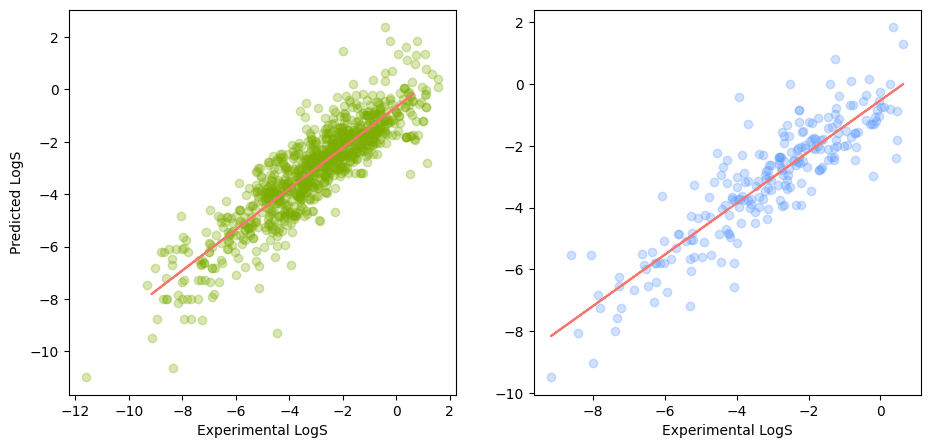

In [42]:
plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()

## **Reference**

1. John S. Delaney. [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x). ***J. Chem. Inf. Comput. Sci.*** 2004, 44, 3, 1000-1005.

2. Pat Walters. [Predicting Aqueous Solubility - It's Harder Than It Looks](http://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html). ***Practical Cheminformatics Blog***




The work of Delaney$^1$ provided the following linear regression equation:

> LogS = 0.16 -  0.63 cLogP - 0.0062 MW + 0.066 RB - 0.74 AP

The reproduction by Pat Walters$^2$ provided the following:

> LogS = 0.26 -  0.74 LogP - 0.0066 MW + 0.0034 RB - 0.42 AP

This notebook's reproduction gave the following equation:

* Based on the Train set
> LogS = 0.30 -0.75 LogP - .0066 MW -0.0041 RB - 0.36 AP

* Based on the Full dataset
> LogS =  0.26 -0.74 LogP - 0.0066 + MW 0.0032 RB - 0.42 AP